# Atmospheric retrieval with petitRADTRANS

This is a tutorial for atmospheric retrievals with [petitRADTRANS](https://petitradtrans.readthedocs.io) for which we will use the [IRTF spectrum](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/index.html) of the L3 type brown dwarf [2MASS J15065441+1321060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=2MASS+J15065441%2B1321060). The spectrum covers the $Y$ to $L$ bands with a resolving power of $R = 2000$.

Free retrievals are computationally expensive due to the high number of parameter dimensions and the scattering radiative transfer that is important in cloudy atmospheres (see [Mollière et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A.131M/abstract)). Similar to [FitModel](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.fit_model.FitModel), the nested sampling supports multiprocessing so it recommended to run the retrievals on a cluster. Before starting, ``petitRADTRANS`` should be installed together with the line and continuum opacities (see [installation instructions](https://petitradtrans.readthedocs.io/en/latest/content/installation.html)).

When running a retrieval, it is important to comment out any of the functions that access the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) because writing to the HDF5 file is not possible with multiprocessing. Therefore, the data of the planet or brown dwarf should first be added to the database (e.g. on a local machine), then [AtmosphericRetrieval](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.retrieval.AtmosphericRetrieval) and [run_multinest](https://species.readthedocs.io/en/latest/species.analysis.html#species.analysis.retrieval.AtmosphericRetrieval.run_multinest) can be executed (preferably on a cluster), and finally the results can be extracted and plotted while commenting out the retrieval part or using a separate script (e.g. on a local machine).

## Getting started

We start by adding the library path of ``MultiNest`` to the ``DYLD_LIBRARY_PATH`` environment variable such that ``PyMultiNest`` can find the compiled library (see [installation instructions](https://johannesbuchner.github.io/PyMultiNest/install.html)).

In [1]:
import os
os.environ['DYLD_LIBRARY_PATH'] = '/Users/tomasstolker/applications/MultiNest/lib'

Next, we import the `species` toolkit and initiate the workflow with an instance of the [SpeciesInit](https://species.readthedocs.io/en/latest/species.core.html#species.core.init.SpeciesInit) class. This will create the [HDF5 database](https://species.readthedocs.io/en/latest/database.html) and the [configuration file](https://species.readthedocs.io/en/latest/configuration.html) in the working folder. If one of these files was already present, then the existing database and/or configuration will be used.

In [2]:
import species
species.SpeciesInit()

species v0.7.1
Working folder: /Users/tomasstolker/applications/species/docs/tutorials
Creating species_config.ini... [DONE]
Configuration settings:
   - Database: /Users/tomasstolker/applications/species/docs/tutorials/species_database.hdf5
   - Data folder: /Users/tomasstolker/applications/species/docs/tutorials/data
   - Interpolation method: linear
   - Magnitude of Vega: 0.03
Creating species_database.hdf5... [DONE]
Creating data folder... [DONE]


## Adding data to the database

The database is used by ``species`` as the central storage for models, data, and results. The data in the HDF5 file is accessed through the [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) class. As mentioned already, it is best to add the data beforehand and comment out the database part when executing the retrieval part on a cluster with multi-core processing. To access the HDF5 file, we start by creating an instance of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [3]:
database = species.Database()

Next, we will download the [IRTF spectrum](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/References_files/L.html) of [2MASS J15065441+1321060](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=2MASS+J15065441%2B1321060), which is an L3 type field brown dwarf.

In [4]:
import urllib.request
urllib.request.urlretrieve('http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/L3_2MASSJ1506+1321.fits',
                           'L3_2MASSJ1506+1321.fits')

('L3_2MASSJ1506+1321.fits', <http.client.HTTPMessage at 0x14d424e50>)

Now that we have a FITS file with a spectrum, we use the [add_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_object) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) to add the spectrum and distance of 2MASS J15065441+1321060 to the `Database`. The distance was calculated from the [parallax](http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=2MASS+J15065441%2B1321060) of the [Gaia Early Data Release 3](http://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G). We also need to specify the spectral resolution, which is used for smoothing the model spectra to the instrument resolving power. For simplicity, we assume a constant resolving power from $Y$ to $L$ band, whereas the actual resolution in the $L$ band is [a bit larger](http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/index.html).

In [5]:
database.add_object('2MASS J15065441+1321060',
                    parallax=(85.4250, 0.1902),
                    app_mag=None,
                    flux_density=None,
                    spectrum={'IRTF': ('L3_2MASSJ1506+1321.fits', None, 2000.)},
                    deredden=None)

Adding object: 2MASS J15065441+1321060
   - Parallax (mas) = 85.42 +/- 0.19
   - Spectrum:
      - Database tag: IRTF
      - Filename: L3_2MASSJ1506+1321.fits
      - Data shape: (5399, 3)
      - Wavelength range (um): 0.93 - 4.10
      - Mean flux (W m-2 um-1): 7.79e-15
      - Mean error (W m-2 um-1): 1.84e-16
   - Spectral resolution:
      - IRTF: 2000.0


/Users/tomasstolker/applications/species/species/data/database.py:1324: UserWarning: Transposing the data of IRTF because the first instead of the second axis has a length of 3.
  warnings.warn(
/Users/tomasstolker/applications/species/species/data/database.py:1341: UserWarning: Found 804 fluxes with NaN in the data of IRTF. Removing the spectral fluxes that contain a NaN.
  warnings.warn(


Now that the data is present in the database, we can run the retrieval! Since running the actual retrieval takes quite some time, we will simply download the results (408 MB) that were stored in the `output_folder` (see below) after running the retrieval on a cluster.

In [6]:
import urllib.request
urllib.request.urlretrieve('https://home.strw.leidenuniv.nl/~stolker/species/retrieval.tgz',
                           'retrieval.tgz')

('retrieval.tgz', <http.client.HTTPMessage at 0x14d937950>)

Let's unpack this compressed TAR archive.

In [7]:
import tarfile
with tarfile.open('retrieval.tgz') as tar:
    tar.extractall('./')

## Atmospheric retrieval of abundances, clouds, and P-T structure

A retrieval is started by creating an instance of [AtmosphericRetrieval](https://species.readthedocs.io/en/latest/species.data.html#species.analysis.retrieval.AtmosphericRetrieval). Several parameters need to be provided, including the database tag to the data (i.e. `object_name`), the line and cloud species that should be included in the forward model (i.e. `line_species` and `cloud_species`), and if scattering should be turned on with the radiative transfer (i.e `scattering`). Scattering will make the calculation of the forward model much slower but is important for cloudy atmospheres.

In [8]:
retrieve = species.AtmosphericRetrieval(object_name='2MASS J15065441+1321060',
                                        line_species=['CO_all_iso_HITEMP', 'H2O_HITEMP', 'CH4', 'NH3', 'CO2', 'Na_allard', 'K_allard', 'TiO_all_Exomol', 'VO_Plez', 'FeH', 'H2S'],
                                        cloud_species=['MgSiO3(c)_cd', 'Fe(c)_cd'],
                                        output_folder='multinest',
                                        wavel_range=(0.9, 4.2),
                                        scattering=True,
                                        inc_spec=True,
                                        inc_phot=False,
                                        pressure_grid='smaller',
                                        weights=None,
                                        ccf_species=None,
                                        max_pressure=1e3,
                                        lbl_opacity_sampling=None)

Object: 2MASS J15065441+1321060
Parallax (mas): 85.4250 +/- 0.1902
Line species:
   - CO_all_iso_HITEMP
   - H2O_HITEMP
   - CH4
   - NH3
   - CO2
   - Na_allard
   - K_allard
   - TiO_all_Exomol
   - VO_Plez
   - FeH
   - H2S
Cloud species:
   - MgSiO3(c)_cd
   - Fe(c)_cd
Cross-correlation species: None
Scattering: True
Opacity mode: correlated-k (lambda/Dlambda = 1,000)
Getting object: 2MASS J15065441+1321060... [DONE]
Spectroscopic data:
   - IRTF
     Wavelength range (um) = 0.93 - 4.10
     Spectral resolution = 2000.00
Initiating 180 pressure levels (bar): 1.00e-06 - 1.00e+03
Weights for the log-likelihood function:
   - IRTF = 1.00e+00


Next, we can run the actual retrieval with [run_multinest](https://species.readthedocs.io/en/latest/species.data.html#species.analysis.retrieval.AtmosphericRetrieval.run_multinest). The nested sampling algorithm supports multiprocessing so make sure to use MPI when running on a cluster. For testing purpose this is not required though since the retrieval also runs without MPI.

The [run_multinest](https://species.readthedocs.io/en/latest/species.data.html#species.analysis.retrieval.AtmosphericRetrieval.run_multinest) method has some parameters that are used by the forward model (e.g. specifying the type of chemistry with `chemistry` and the P-T parametrization with `pt_profile`). There is also a dictionary required as argument of `bounds`, to set the boundaries of the priors that are either uniform or log-uniform priors. The latter is for parameters typically starting with `log_`. There is an additional parameter called `prior`, which can be used as Gaussian prior on any of the parameters (including the planet mass).

Not all the parameters that are included in `bounds` are mandatory so some will only be included in the model if they are provided in the dictionary. Furthermore, there are various parametrizations for the clouds available. The model that is used is partially determined by the parameters that are included. In fact, in the example below, only the surface gravity (`logg`) and radius (`radius`) are mandatory parameters.

In this case, the C/O ratio and metallicity are free parameter because we are using a chemical equilibrium model. We also retrieve the cloud mass fractions relative to the equilibrium abundances (`mgsio3_fraction` and `fe_fraction`), the sedimentation parameter (`fsed`; determines the vertical extent of the clouds), the eddy diffusion coefficient (`log_kzz`; determines the particles sizes of the clouds), and the width of the log-normal size distribution (`sigma_lnorm`) for the cloud particles.

With `plotting=True`, each model iteration would save several plots, which can be inspected for testing purpose. It is best set the argument to `False` when running the full retrieval. There is also the possibility to continue a retrieval that was interrupted by setting `resume=True` (as long as the input parameters have not changed) because `MultiNest` continuously updates the data in the `output_folder`. Since we have downloaded the completed retrieval results, we will set `resume=True`. In this case, the retrieval will finish directly because the posterior distribution was already fully sampled at the requested accuracy, so in principle the [run_multinest](https://species.readthedocs.io/en/latest/species.data.html#species.analysis.retrieval.AtmosphericRetrieval.run_multinest) could also be skipped.

In [9]:
retrieve.run_multinest(bounds={'logg': (2.5, 6.0),
                               'c_o_ratio': (0.1, 1.5),
                               'metallicity': (-3., 3.),
                               'radius': (0.5, 2.),
                               'mgsio3_fraction': (-2., 1.),
                               'fe_fraction': (-2., 1.),
                               'fsed': (0., 20.),
                               'log_kzz': (2., 15.),
                               'sigma_lnorm': (1.2, 5.)},
                       chemistry='equilibrium',
                       quenching='pressure',
                       pt_profile='monotonic',
                       fit_corr=None,
                       n_live_points=1000,
                       resume=True,
                       plotting=False,
                       pt_smooth=0.3,
                       temp_nodes=None,
                       abund_nodes=None,
                       prior=None,
                       check_phot_press=None)

Importing petitRADTRANS... [DONE]
Importing chemistry module... [DONE]
Importing rebin module...

 [DONE]
Setting up petitRADTRANS...


/Users/tomasstolker/applications/species/species/analysis/retrieval.py:1118: UserWarning: The maximum spectral resolution of the input data is R = 2000.0 whereas the 'res_mode' argument has been set to 'c-k' (i.e. correlated-k mode). It is recommended to set the 'res_mode' argument to 'lbl' (i.e. line-by-line mode) instead.
  warnings.warn("The maximum spectral resolution of "
/Users/tomasstolker/applications/petitradtrans/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CO_all_iso_HITEMP...
  Read line opacities of H2O_HITEMP...
  Read line opacities of CH4...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of Na_allard...
  Read line opacities of K_allard...
  Read line opacities of TiO_all_Exomol...
  Read line opacities of VO_Plez...
  Read line opacities of FeH...
 Done.
  Read line opacities of H2S...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Fitting 26 parameters:
   - logg
   - radius
   - parallax
   - t0
   - t1
   - t2
   - t3
   - t4
   - t5
   - t6
   - t7
   - t8
   - t9
   - t10
   - t11
   - t12
   - t13
   - t14
   - metallicity
   - c_o_ratio
   - log_p_quench
   - fsed
   - log_kzz
   - sigma_lnorm
   - mgsio3_fraction
   - fe_fraction
Number of pressure levels used with the radiative transfer: 60
Storing the model parameter

As expected, the retrieval finishes directly after starting because it read the completed results from the `output_folder`.

## Nested sampling output folder

The output data from the nested sampling with ``MultiNest`` is stored in the ``output_folder``. After running the retrieval, we can use the [add_retrieval](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.add_retrieval) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) to store the posterior samples from the ``output_folder``, together with the relevant attributes, in the HDF5 database. The argument of ``tag`` is used as name tag in the database and will be used later on for processing the results. It is also possible to calculate $T_\mathrm{eff}$ for each sample but this takes a long time because each spectrum needs to be calculated over a broad wavelength range.

In [10]:
database.add_retrieval(tag='2mj1506',
                       output_folder='multinest',
                       inc_teff=False)

Storing samples in the database... [DONE]


Instead of using the `inc_teff` parameter of `add_retrieval`, we use the [get_retrieval_teff](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_retrieval_teff) method to estimate $T_\mathrm{eff}$ from a small number of samples (30 in the example below). The value is stored in the database as attribute of the group that is specified with the argument of ``tag``.

In [11]:
_, _ = database.get_retrieval_teff(tag='2mj1506',
                                   random=30)

Calculating Teff from 30 posterior samples... 
Importing petitRADTRANS... [DONE]
  Read line opacities of CO_all_iso_HITEMP...
  Read line opacities of H2O_HITEMP...
  Read line opacities of CH4...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of Na_allard...
  Read line opacities of K_allard...
  Read line opacities of TiO_all_Exomol...
  Read line opacities of VO_Plez...
  Read line opacities of FeH...
 Done.
  Read line opacities of H2S...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Getting posterior spectra 30/30... [DONE]
Teff (K) = 1876.32 (-0.47 +0.36)
log(L/Lsun) = -4.01 (-0.00 +0.00)
Storing Teff (K) as attribute of results/fit/2mj1506/samples... [DONE]
Storing log(L/Lsun) as attribute of results/fit/2mj1506/samples... [DONE]


## Plotting the posterior distributions

We can now read the posterior samples from the database and use the plot functionalities to visualize the results. Let's first plot the marginalized posterior distributions with the [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function. This function makes use of the [corner.py](https://corner.readthedocs.io) package. Since there are many free parameters, we will exclude the parameters for P-T profile by setting `inc_pt_param=False`. By setting `output=None`, the plot is shown instead of written to a file.

Median sample:
   - logg = 5.66e+00
   - radius = 9.16e-01
   - parallax = 8.55e+01
   - t0 = 1.14e+03
   - t1 = 1.14e+03
   - t2 = 1.14e+03
   - t3 = 1.14e+03
   - t4 = 1.15e+03
   - t5 = 1.16e+03
   - t6 = 1.17e+03
   - t7 = 1.26e+03
   - t8 = 1.42e+03
   - t9 = 1.69e+03
   - t10 = 1.98e+03
   - t11 = 2.53e+03
   - t12 = 3.23e+03
   - t13 = 4.55e+03
   - t14 = 1.33e+04
   - metallicity = 9.38e-01
   - c_o_ratio = 6.15e-01
   - log_p_quench = -2.05e-01
   - fsed = 8.93e+00
   - log_kzz = 5.39e+00
   - sigma_lnorm = 1.36e+00
   - mgsio3_fraction = -9.62e-01
   - fe_fraction = 2.73e-01
   - pt_smooth = 3.00e-01
Maximum posterior sample:
   - logg = 5.65e+00
   - radius = 9.14e-01
   - parallax = 8.56e+01
   - t0 = 1.18e+03
   - t1 = 1.18e+03
   - t2 = 1.18e+03
   - t3 = 1.18e+03
   - t4 = 1.19e+03
   - t5 = 1.19e+03
   - t6 = 1.20e+03
   - t7 = 1.27e+03
   - t8 = 1.42e+03
   - t9 = 1.69e+03
   - t10 = 1.97e+03
   - t11 = 2.53e+03
   - t12 = 3.21e+03
   - t13 = 4.53e+03
   - t14 = 1.33e+

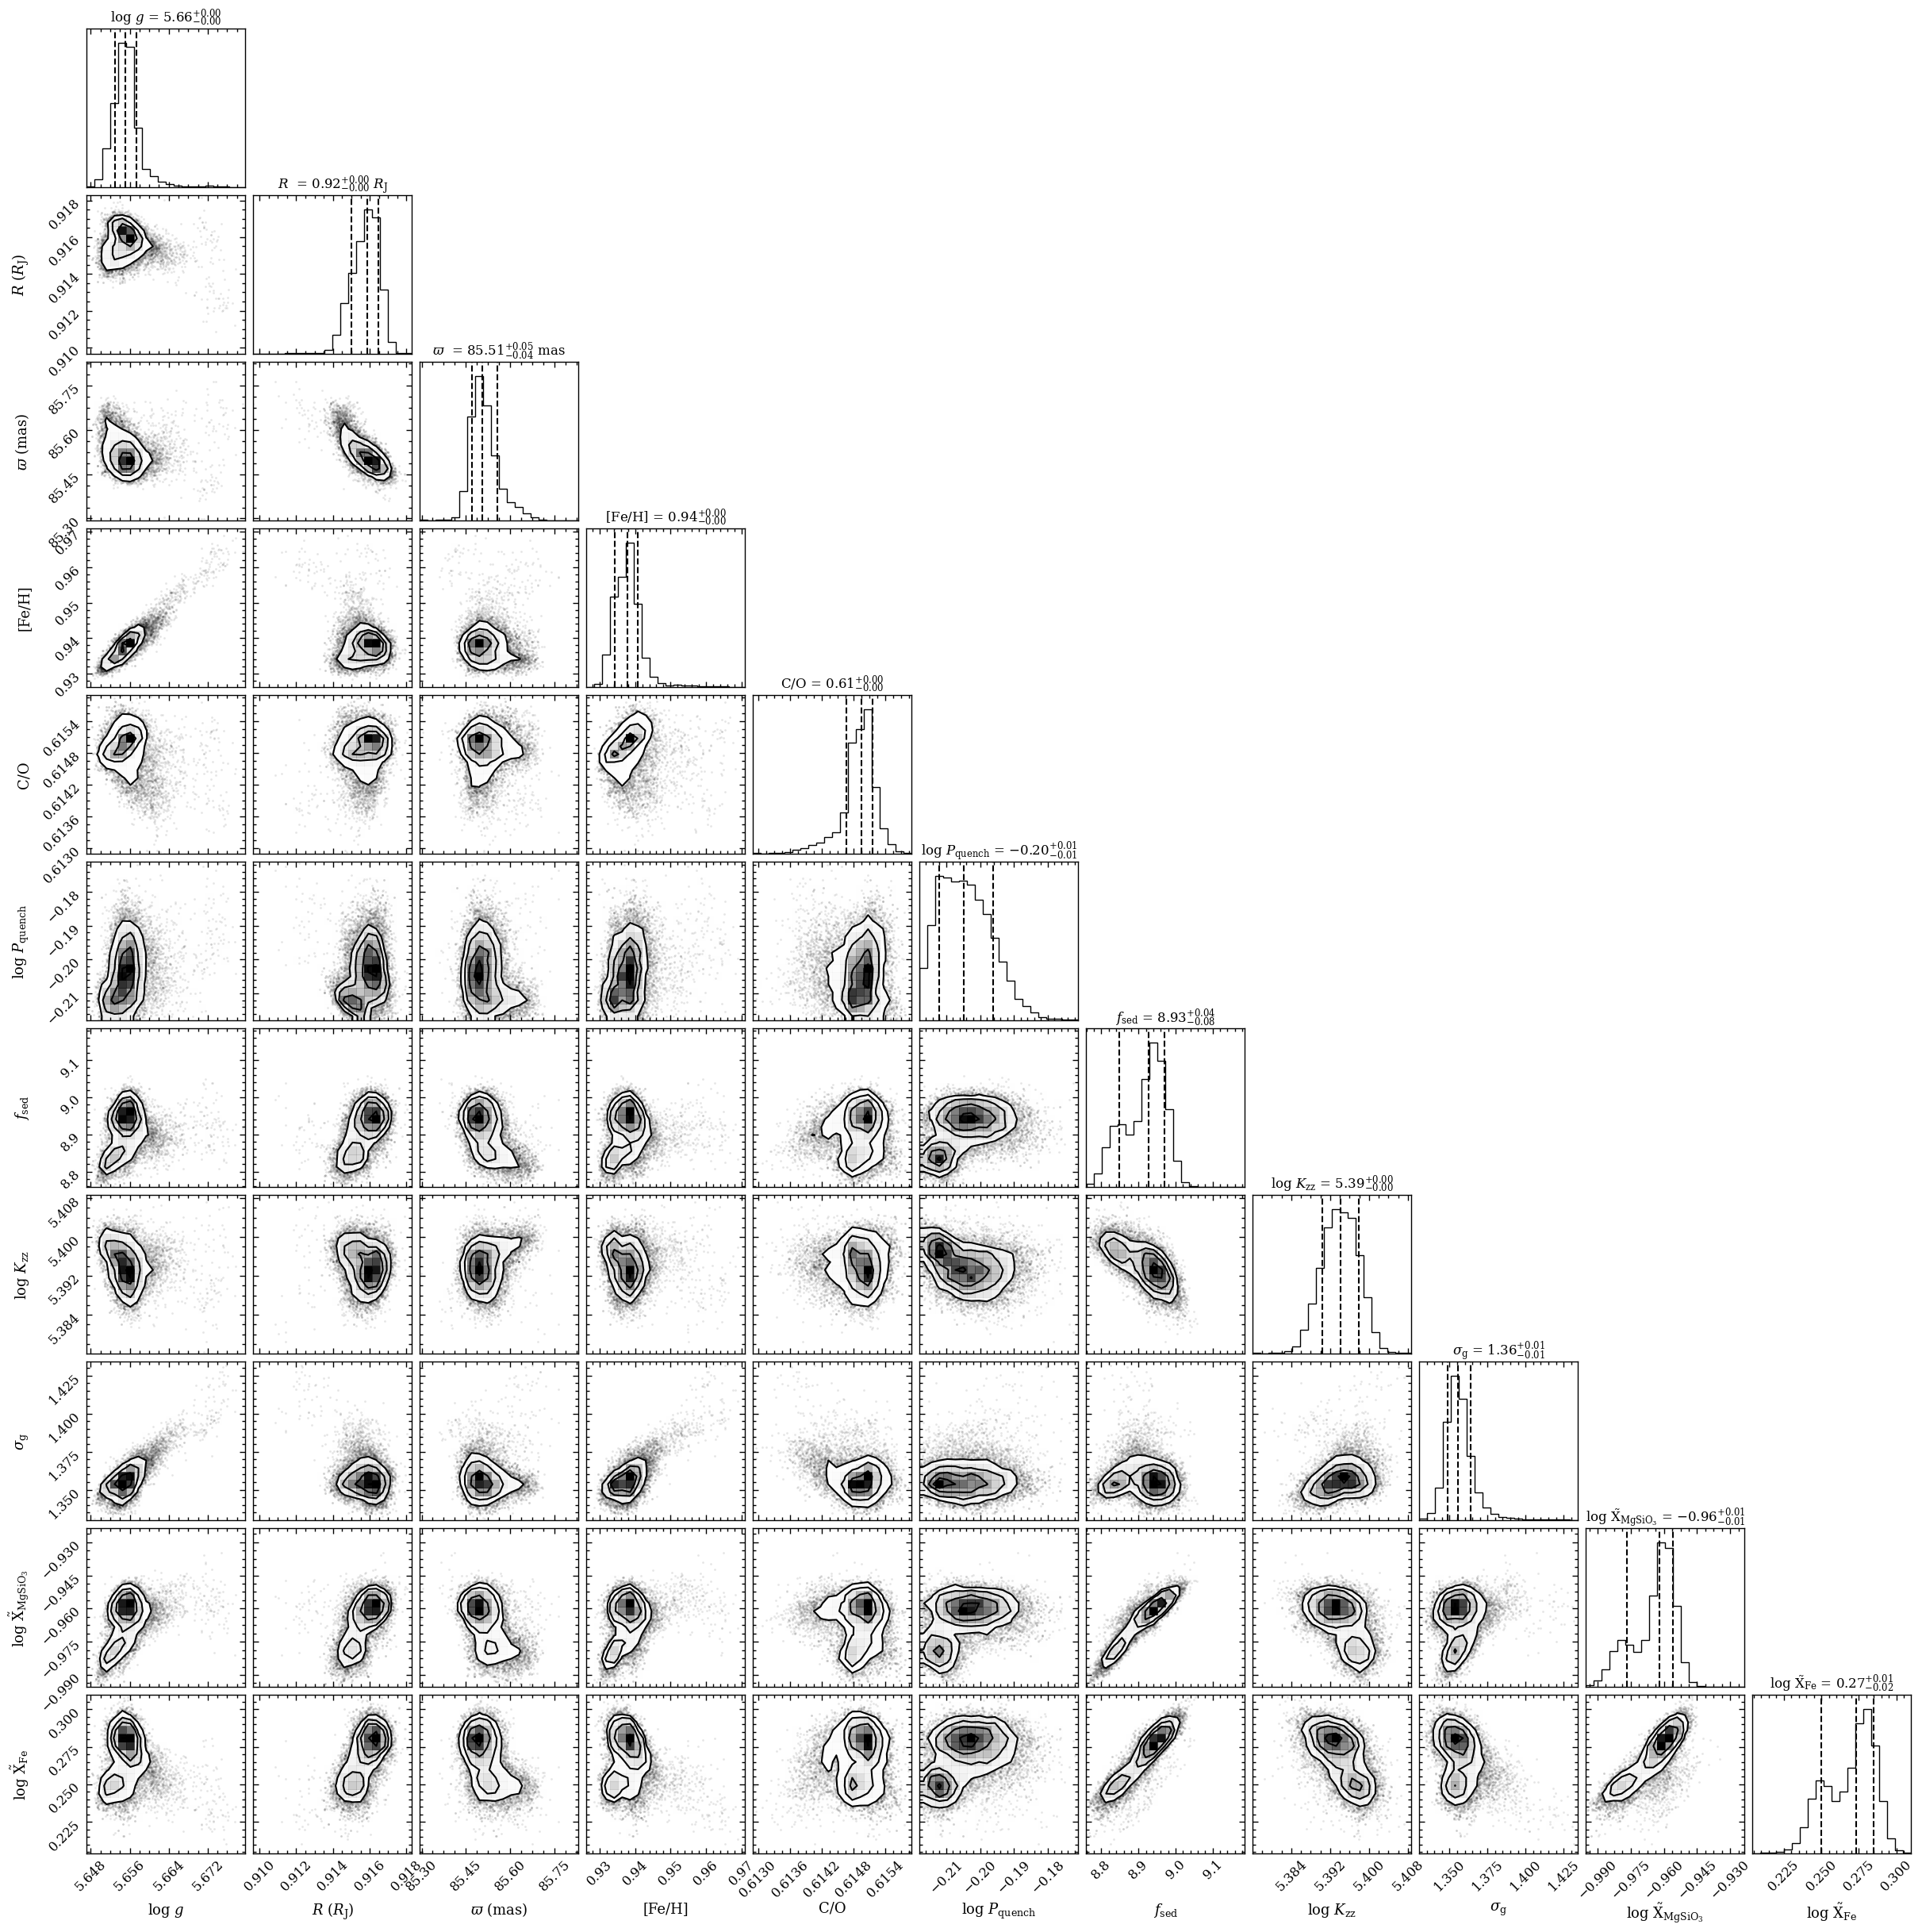

 [DONE]


In [12]:
fig = species.plot_posterior(tag='2mj1506',
                             offset=(-0.3, -0.35),
                             vmr=False,
                             inc_luminosity=False,
                             inc_mass=False,
                             inc_pt_param=False,
                             inc_loglike=False,
                             output=None)

The [plot_posterior](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_posterior) function returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The functionalities of [Matplotlib](https://matplotlib.org/stable/index.html) can be used for further customization of the plot.

## ReadRadtrans and random spectra

In order to post-process the posterior samples, we need to recreate the ``Radtrans`` object of ``petitRADTRANS``. Todo so, we use the [get_retrieval_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_retrieval_spectra) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database) to create and instance of [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) with the adopted parameters that were set with the retrieval. The ``Radtrans`` object is stored as an attribute of the ``ReadRadtrans`` object. The ``ReadRadtrans`` object can simply be passed to some of the ``species`` functions later on and can typically be ignored by the user. The method also returns a list of random spectra (30 in the example below) that have been recalculated at a resolving power of $R = 2000$. Each spectrum is stored in a [ModelBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ModelBox) together with the atmospheric parameters.

In [13]:
samples, radtrans = database.get_retrieval_spectra(tag='2mj1506',
                                                   random=30,
                                                   wavel_range=(0.5, 6.),
                                                   spec_res=2000.)

Importing petitRADTRANS... [DONE]


/Users/tomasstolker/applications/petitradtrans/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CO_all_iso_HITEMP...
  Read line opacities of H2O_HITEMP...
  Read line opacities of CH4...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of Na_allard...
  Read line opacities of K_allard...
  Read line opacities of TiO_all_Exomol...
  Read line opacities of VO_Plez...
  Read line opacities of FeH...
 Done.
  Read line opacities of H2S...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Getting posterior spectra 30/30... [DONE]


Let's have a look at the content of first `ModelBox` by using the [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box) method.

In [14]:
samples[0].open_box()

Opening ModelBox...
model = petitradtrans
type = mcmc
wavelength = [0.50018561 0.50068604 0.50118698 ... 5.98480622 5.99079402 5.99678781]
flux = [7.53219791e-17 7.43663609e-17 7.33942257e-17 ... 4.73241595e-16
 4.60450841e-16 4.85040144e-16]
parameters = {'logg': 5.656868827435394, 'radius': 0.9159971186035384, 'distance': 11.706175007316359, 't0': 1154.8392229121648, 't1': 1155.224681478477, 't2': 1155.7720647576928, 't3': 1156.422789557656, 't4': 1163.025271014466, 't5': 1171.4445464045486, 't6': 1189.3763986427784, 't7': 1272.8491851271408, 't8': 1416.1932327305638, 't9': 1692.3811854786045, 't10': 1975.8243981704834, 't11': 2526.8980547333513, 't12': 3242.405779583647, 't13': 4578.0814059672575, 't14': 13373.56326312204, 'pt_smooth': 0.3, 'c_o_ratio': 0.6154461893559895, 'metallicity': 0.9411162325341786, 'log_p_quench': -0.20602046402432705, 'fsed': 8.944467694114131, 'sigma_lnorm': 1.3565697018316165, 'log_kzz': 5.390598664912041, 'mgsio3_fraction': -0.9623759352887191, 'fe_frac

## Plotting the P-T profiles, opacities, and clouds

We will now create some additional plots for analyzing the retrieved atmospheric structure. First, we will use the [plot_pt_profile](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_mcmc.plot_pt_profile) function for selecting random samples (100 in the example below) from the posterior distribution and recalculating the P-T profiles. We set the database `tag` were the posterior samples and attributes are stored and additionally the `extra_axis` (i.e. the top $x$ axis) that we want to use for showing the average particle radius of the MgSiO$_3$ and Fe clouds as function of pressure. These are average particle sizes but particle smaller than 1 nm are excluded from the actual size distribution. The condensation profiles of these cloud species are also shown with colored dashed lines.

The parametrization of the P-T profiles used 15 free nodes that are monotonically increasing with pressure and shown for the median parameters. The free nodes are interpolated and smoothed with a Gaussian kernel of $\sigma = 0.3$ dex in pressure, hence there is a slight difference between the sampled temperature nodes and the actual P-T profiles.

The P-T profile from the median sample is shown with a black solid line will the 100 random samples are shown with thin gray lines. Given the large number of spectral data points, we get a very good constraints on all retrieved parameters, so it would probably warrant the inclusion of additional parameters to give the model more freedom.

Plotting the P-T profiles...

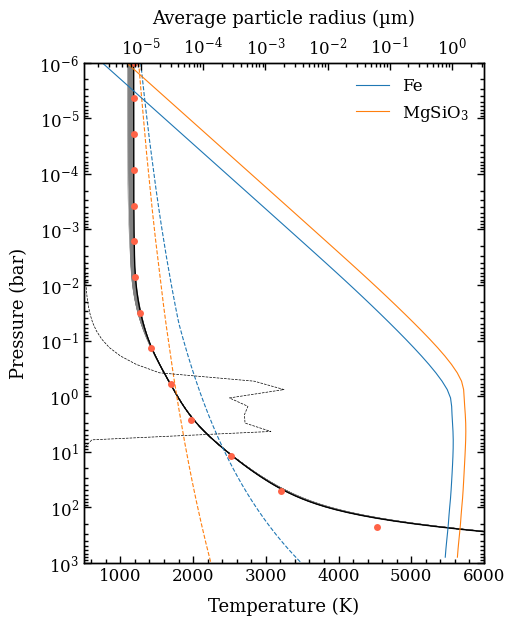

 [DONE]


In [15]:
fig = species.plot_pt_profile(tag='2mj1506',
                              random=100,
                              xlim=(500., 6000.),
                              offset=(-0.07, -0.14),
                              output=None,
                              radtrans=radtrans,
                              extra_axis='grains',
                              rad_conv_bound=False)

The [plot_pt_profile](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_retrieval.plot_pt_profile) function also returned the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot. The axes of the `Figure` are stored as the `axes` attribute.

In [16]:
fig.axes

[<Axes: xlabel='Temperature (K)', ylabel='Pressure (bar)'>,
 <Axes: xlabel='Average particle radius (µm)'>]

Next, we use the [plot_opacities](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_retrieval.plot_opacities) function for plotting the line and continuum opacities for the atmospheric structure of the median retrieved parameters. We pass again the [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) object as argument of `radtrans`, which was earlier returned by [get_retrieval_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_retrieval_spectra). The single scattering albedo is calculated as $\omega = \frac{\kappa_\mathrm{cont,scat}}{\kappa_\mathrm{line} + \kappa_\mathrm{cont,abs} + \kappa_\mathrm{cont,scat}}$. The scattering opacity is dominated by the cloud decks of the two clouds species but the $\lambda^{-4}$ dependence of the Rayleigh scattering form gas is also seen in the mass opacities, but the impact on the spectrum at infrared wavelengths is typically negligible. The function returns again the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure) object of the plot.

Plotting opacities...

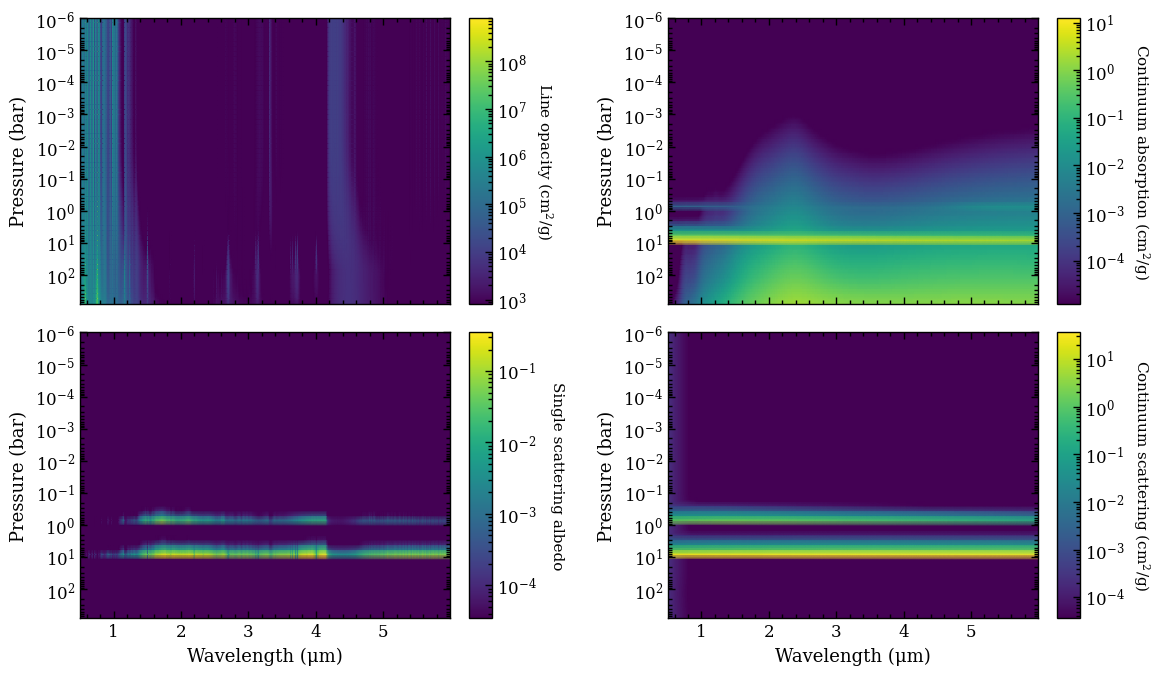

 [DONE]


In [17]:
fig = species.plot_opacities(tag='2mj1506',
                             offset=(-0.1, -0.14),
                             output=None,
                             radtrans=radtrans)

For the cloud model, we used the parametrization from [Mollière et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...640A.131M/abstract), which determines the cloud base through the intersection of the condensation profiles of the cloud species with the P-T profile. The vertical cloud structure is controlled by the $f_\mathrm{sed}$ parameter and the average particle sizes by the eddy diffusion coefficient, $K_\mathrm{zz}$. Furthermore, it uses a log-normal size distribution for the cloud particle with the width, $\sigma_\mathrm{g}$, as free parameter. We can plot the size distributions as function of pressure with the [plot_clouds](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_retrieval.plot_clouds). Here, we need to specify one of the two cloud species that were included with the retrieval and we need to provide again the [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) object.

Plotting MgSiO3 clouds...

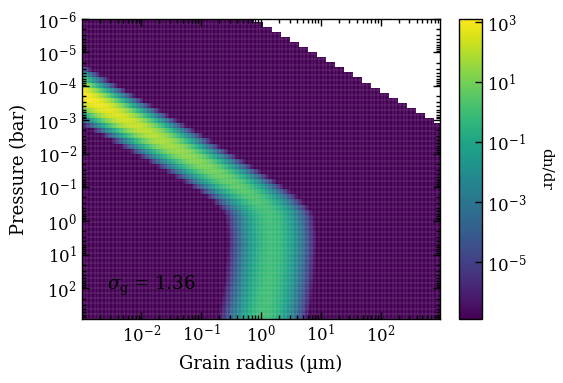

 [DONE]


In [18]:
fig = species.plot_clouds(tag='2mj1506',
                          offset=(-0.12, -0.15),
                          output=None,
                          radtrans=radtrans,
                          composition='MgSiO3')

## Creating a Box with the observed spectrum

After getting an impression of the retrieved atmospheric structure, we will create a plot of the data and model spectra. To do so, we need several functions to extract the relevant data from the database. First, we create an [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) with the data (only a spectrum in this case) of 2MASS J15065441+1321060 by using the [get_object](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_object) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [19]:
object_box = database.get_object('2MASS J15065441+1321060')

Getting object: 2MASS J15065441+1321060... [DONE]


Let's have a look at the content of the `ObjectBox` with [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box). This method can be used on any [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) object.

In [20]:
object_box.open_box()

Opening ObjectBox...
name = 2MASS J15065441+1321060
filters = []
mean_wavel = {}
magnitude = {}
flux = {}
spectrum = {'IRTF': (array([[9.3171155e-01, 6.2615632e-15, 1.2361384e-15],
       [9.3198341e-01, 5.5975380e-15, 1.1189908e-15],
       [9.3225533e-01, 6.5201217e-15, 9.6139224e-16],
       ...,
       [4.0973549e+00, 1.8983273e-15, 4.6716408e-16],
       [4.0981603e+00, 1.8976329e-15, 4.6592032e-16],
       [4.0989652e+00, 1.6915271e-15, 4.6575150e-16]], dtype=float32), None, None, 2000.0)}
parallax = [85.425   0.1902]
distance = None


## Best-fit spectrum and residuals

We already drew 30 random spectra from the posterior distribution with [get_retrieval_spectra](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_retrieval_spectra), but in addition we will compute the spectrum with the best-fit parameters. Here, we adopt the median retrieved parameters as the best-fit values. We start extracting the median values with the [get_median_sample](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database.get_median_sample) method of [Database](https://species.readthedocs.io/en/latest/species.data.html#species.data.database.Database).

In [21]:
best = database.get_median_sample(tag='2mj1506')

The atmospheric parameters are stored in a dictionary. Some of the parameters, such as the `distance` and `pt_smooth` may not have been free parameters with the retrieval though, but are required for computing the spectrum.

Next, we will compute the `petitRADTRANS` spectrum for the best-fit parameters at $R = 2000$. The [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans.get_model) method of the [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) object requires a the dictionary with parameters as argument. We also set `plot_contribution=True` such that a plot of the emission contribution as function of pressure wavelength is shown.

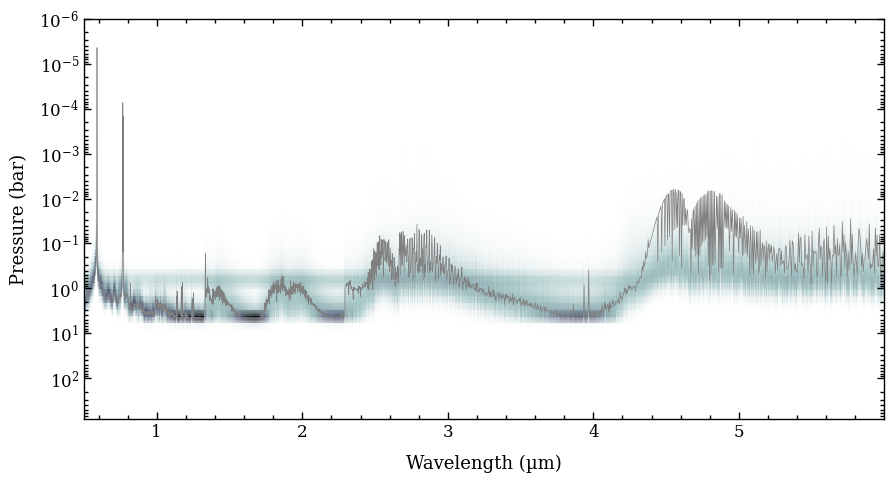

In [22]:
model_box = radtrans.get_model(model_param=best,
                               spec_res=2000.,
                               wavel_resample=None,
                               plot_contribution=True)

With the parameter dictionary, the [ObjectBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ObjectBox) with data, and the [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) object, we can calculate the residuals (i.e. data minus model) of the best-fit spectrum. To do so, we use the [get_residuals](https://species.readthedocs.io/en/latest/species.util.html#species.util.phot_util.get_residuals) function, which calculates the residuals (relative to the data uncertainties) for each spectrum (only one in this case) and photometric flux, together with the reduced $\chi^2$.

In [23]:
res_box = species.get_residuals(datatype='model',
                                spectrum='petitradtrans',
                                parameters=best,
                                objectbox=object_box,
                                inc_phot=True,
                                inc_spec=True,
                                radtrans=radtrans)

Calculating synthetic photometry... [DONE]
Calculating residuals... [DONE]
Residuals (sigma):
   - IRTF: min: -33.39, max: 47.07
Reduced chi2 = 26.56
Number of degrees of freedom = 5372


Let's have a look at the content of the returned [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) with [open_box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box.open_box).

In [24]:
res_box.open_box()

Opening ResidualsBox...
name = 2MASS J15065441+1321060
photometry = {}
spectrum = {'IRTF': array([[ 0.93171155, -1.54559162],
       [ 0.93198341, -2.30081457],
       [ 0.93225533, -1.3287664 ],
       ...,
       [ 4.09735489, -0.08368848],
       [ 4.09816027, -0.08540217],
       [ 4.09896517, -0.63846515]])}
chi2_red = 26.558472584495007


For comparison, we calculate a spectrum without the clouds to see their effect of the spectrum. This is done by simply setting the cloud mass fractions to $10^{-100}$ and rerunning [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans.get_model) with the updated parameter dictionary.

In [25]:
no_cloud = best.copy()
no_cloud['mgsio3_fraction'] = -100.
no_cloud['fe_fraction'] = -100.
model_no_cloud = radtrans.get_model(no_cloud, spec_res=2000.)

Furthermore, we calculate a spectrum without accounting for scattering from (mainly) clouds to see the importance of scattering in the radiative transfer of cloudy atmospheres. We need to set the `do_scat_emis` and `test_ck_shuffle_comp` attributes of the `Radtrans` object (i.e. the `rt_object` of [ReadRadtrans](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans) ) to `False` and rerun [get_model](https://species.readthedocs.io/en/latest/species.read.html#species.read.read_radtrans.ReadRadtrans.get_model) with the best-fit parameters.

In [26]:
radtrans.rt_object.do_scat_emis = False
radtrans.rt_object.test_ck_shuffle_comp = False
model_no_scat = radtrans.get_model(best, spec_res=2000.)

## Plotting the SED with data and model spectra

We are now ready to create a plot of the spectral energy distribution (SED) to compare the data with the model spectra! The [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function requires a list of [Box](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.Box) objects as argument of `boxes` and the [ResidualsBox](https://species.readthedocs.io/en/latest/species.core.html#species.core.box.ResidualsBox) is passed as separate argument of `residuals`. For each box we can set the plot style, by providing a list with dictionaries as argument of `plot_kwargs`, in the same order as the list of `boxes`. Items in the list can be set to `None`, in which case some default values are used. Finally, there is a handful of parameters that can be adjusted for the appearance of the plot (see the API documentation of [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) for details).

Plotting spectrum...

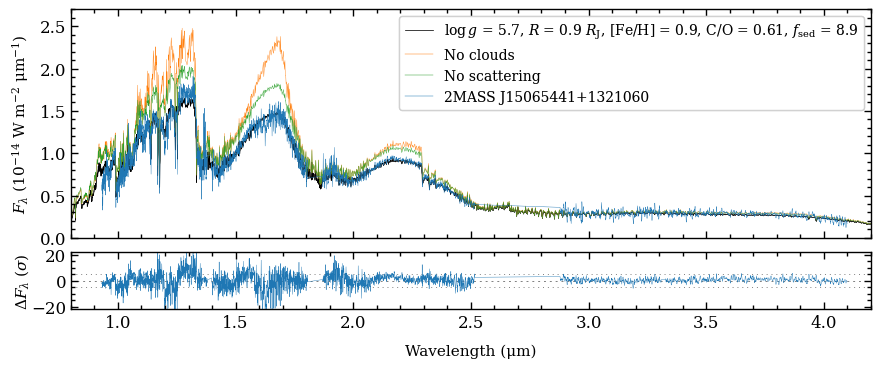

 [DONE]


In [27]:
fig = species.plot_spectrum(boxes=[samples, model_box, model_no_cloud, model_no_scat, object_box],
                            filters=None,
                            plot_kwargs=[{'ls': '-', 'lw': 0.1, 'color': 'gray'},
                                         {'ls': '-', 'lw': 0.5, 'color': 'black'},
                                         {'ls': '-', 'lw': 0.3, 'color': 'tab:orange', 'label': 'No clouds'},
                                         {'ls': '-', 'lw': 0.3, 'color': 'tab:green', 'label': 'No scattering'},
                                         {'IRTF': {'ls': '-', 'lw': 0.3, 'color': 'tab:blue', 'label': '2MASS J15065441+1321060'}}],
                            residuals=res_box,
                            xlim=(0.8, 4.2),
                            ylim=(0., 2.7e-14),
                            ylim_res=(-22., 22.),
                            scale=('linear', 'linear'),
                            offset=(-0.6, -0.05),
                            figsize=(8, 3),
                            legend=[{'loc': 'upper right', 'fontsize': 10.}, None],
                            output=None)

We can clearly see the impact of the clouds, which dampens the molecular absorption bands. The comparison also shows that scattering is important since the spectral fluxes would be overestimated otherwise.

Let's zoom in on the $Y$ and $J$ bands to reveal the spectral features from species such as H$_2$O, FeH, Na, and K more clearly. Instead of rerunning the [plot_spectrum](https://species.readthedocs.io/en/latest/species.plot.html#species.plot.plot_spectrum.plot_spectrum) function, we simply adjust the limits of the first item of the list with axes of the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure).

In [28]:
fig.axes[0].set_xlim(0.9, 1.4)
fig.axes[1].set_xlim(0.9, 1.4)

(0.9, 1.4)

We can plot again the figure by calling the `Figure` object. The plot can be stored with the [savefig](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.savefig) method of the [Figure](https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure).

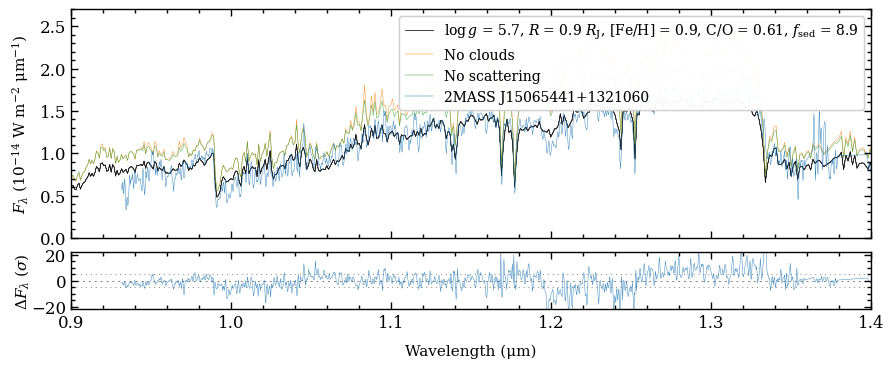

In [29]:
fig